In [79]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

1. Предобработка данных:  
— Очистите данные от пропусков и аномалий.  
— Преобразуйте категориальные переменные с помощью One-Hot Encoding или Label Encoding.

In [80]:
df = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')

In [81]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


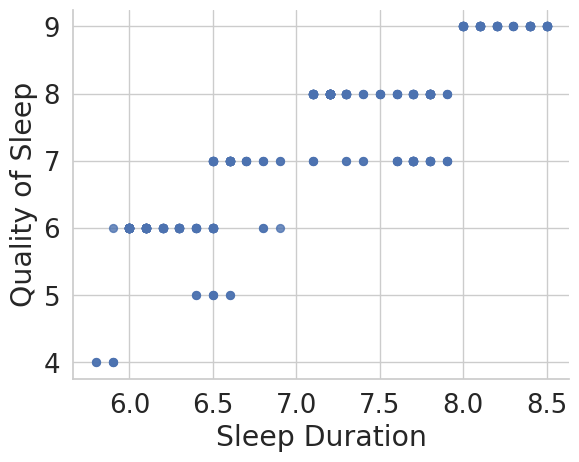

In [82]:
# @title Sleep Duration vs Quality of Sleep

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Sleep Duration', y='Quality of Sleep', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [84]:
df.duplicated().sum()

0

In [85]:
df['Sleep Disorder'].value_counts()

,count
Sleep Disorder,
Sleep Apnea,78
Insomnia,77


Пропусков в датасете фактически нет, но в колонке Sleep Disorder следует заменить NaN на No, тогда она будет отражать суть. К тому же это наша целевая колонка и мы не можем разбивать ее на три колонки.
Кодирования также требуют колонки Gender, Occupation, BMI Category.  
Также потребуется что-то сделать с колонкой Blood Pressure, так как пока она не понятна для модели.

In [86]:
df['Sleep Disorder'] = df['Sleep Disorder']. fillna ('No')

In [87]:
# from sklearn. preprocessing import OneHotEncoder

# encoder = OneHotEncoder(handle_unknown='ignore')
# encoder_df = pd.DataFrame(encoder. fit_transform(df[['Sleep Disorder']]). toarray ())
# df = pd.concat([df, encoder_df], axis=1).drop('Sleep Disorder', axis=1)
# df.rename(columns={0: 'Insomnia', 1: 'No_Disorder', 2: 'Sleep Apnea'}, inplace = True )

In [88]:
df['Sleep_Disorder'] = df['Sleep Disorder'].map({
    'No': 0,
    'Sleep Apnea': 2,
    'Insomnia': 1
})
df = df.drop('Sleep Disorder', axis=1)

In [89]:
df['Gender'].value_counts()

,count
Gender,
Male,189
Female,185


In [90]:
df['BMI Category'].value_counts()

,count
BMI Category,
Normal,195
Overweight,148
Normal Weight,21
Obese,10


In [91]:
df.loc[df['BMI Category'] == 'Normal Weight', 'BMI Category'] = 'Normal'

In [92]:
from sklearn.preprocessing import LabelEncoder
selected_columns = df.loc[:, ['Gender', 'BMI Category']]
label_encoder = LabelEncoder()

# Кодирование столбцов
encoded_columns = {}
for column in selected_columns:
    df[column + '_encoded'] = label_encoder.fit_transform(df[column])
    # Сохраняем маппинг
    encoded_columns[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Вывод DataFrame
display(df)

# Вывод легенды кодировки для каждого столбца
for column, mapping in encoded_columns.items():
    print(f"Кодировка для {column}:", mapping)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep_Disorder,Gender_encoded,BMI Category_encoded
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,0,1,2
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,1,0
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,0,1,0
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,2,1,1
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,2,0,2
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,2,0,2
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,2,0,2
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,2,0,2


Кодировка для Gender: {'Female': 0, 'Male': 1}
Кодировка для BMI Category: {'Normal': 0, 'Obese': 1, 'Overweight': 2}


In [93]:
df.drop(['Gender', 'BMI Category'], axis = 1, inplace=True)

In [94]:
df['Occupation'].value_counts()

,count
Occupation,
Nurse,73
Doctor,71
Engineer,63
Lawyer,47
Teacher,40
Accountant,37
Salesperson,32
Software Engineer,4
Scientist,4


In [95]:
df.loc[df['Occupation'] == 'Sales Representative', 'Occupation'] = 'Salesperson'

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Создание экземпляра TfidfVectorizer
vectorizer = TfidfVectorizer()

# Преобразование документов в TF-IDF векторы
tfidf_matrix = vectorizer.fit_transform(df['Occupation'])
# Просмотр результатов
print(tfidf_matrix)

# Для получения словаря терминов
print(vectorizer.get_feature_names_out())

  (0, 8)	0.8911405202917568
  (0, 2)	0.45372742158055335
  (1, 1)	1.0
  (2, 1)	1.0
  (3, 6)	1.0
  (4, 6)	1.0
  (5, 8)	0.8911405202917568
  (5, 2)	0.45372742158055335
  (6, 9)	1.0
  (7, 1)	1.0
  (8, 1)	1.0
  (9, 1)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 1)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 1)	1.0
  (16, 5)	1.0
  (17, 1)	1.0
  (18, 5)	1.0
  (19, 1)	1.0
  (20, 1)	1.0
  (21, 1)	1.0
  (22, 1)	1.0
  :	:
  (349, 5)	1.0
  (350, 5)	1.0
  (351, 5)	1.0
  (352, 5)	1.0
  (353, 5)	1.0
  (354, 5)	1.0
  (355, 5)	1.0
  (356, 5)	1.0
  (357, 5)	1.0
  (358, 5)	1.0
  (359, 5)	1.0
  (360, 5)	1.0
  (361, 5)	1.0
  (362, 5)	1.0
  (363, 5)	1.0
  (364, 5)	1.0
  (365, 5)	1.0
  (366, 5)	1.0
  (367, 5)	1.0
  (368, 5)	1.0
  (369, 5)	1.0
  (370, 5)	1.0
  (371, 5)	1.0
  (372, 5)	1.0
  (373, 5)	1.0
['accountant' 'doctor' 'engineer' 'lawyer' 'manager' 'nurse' 'salesperson'
 'scientist' 'software' 'teacher']


In [97]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Конкатенируем исходный DataFrame с новым DataFrame векторов TF-IDF
df = pd.concat([df, tfidf_df], axis=1).drop('Occupation', axis=1)

In [98]:
df

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Blood Pressure,Heart Rate,Daily Steps,Sleep_Disorder,...,accountant,doctor,engineer,lawyer,manager,nurse,salesperson,scientist,software,teacher
0,1,27,6.1,6,42,6,126/83,77,4200,0,...,0.0,0.0,0.453727,0.0,0.0,0.0,0.0,0.0,0.891141,0.0
1,2,28,6.2,6,60,8,125/80,75,10000,0,...,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,3,28,6.2,6,60,8,125/80,75,10000,0,...,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,4,28,5.9,4,30,8,140/90,85,3000,2,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0
4,5,28,5.9,4,30,8,140/90,85,3000,2,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,59,8.1,9,75,3,140/95,68,7000,2,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0
370,371,59,8.0,9,75,3,140/95,68,7000,2,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0
371,372,59,8.1,9,75,3,140/95,68,7000,2,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0
372,373,59,8.1,9,75,3,140/95,68,7000,2,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0


2. Генерация новых признаков:  
— Создайте комбинированные признаки, которые могут помочь улучшить модель.  
— Используйте полиномиальные признаки для числовых переменных.

In [99]:
df['systolic_pressure'] = df['Blood Pressure'].str.split('/').str[0].astype(int)
df['diastolic_pressure'] = df['Blood Pressure'].str.split('/').str[1].astype(int)

In [100]:
df = df.drop('Blood Pressure', axis=1)

In [101]:
df

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep_Disorder,Gender_encoded,...,engineer,lawyer,manager,nurse,salesperson,scientist,software,teacher,systolic_pressure,diastolic_pressure
0,1,27,6.1,6,42,6,77,4200,0,1,...,0.453727,0.0,0.0,0.0,0.0,0.0,0.891141,0.0,126,83
1,2,28,6.2,6,60,8,75,10000,0,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,125,80
2,3,28,6.2,6,60,8,75,10000,0,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,125,80
3,4,28,5.9,4,30,8,85,3000,2,1,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,140,90
4,5,28,5.9,4,30,8,85,3000,2,1,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,59,8.1,9,75,3,68,7000,2,0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,140,95
370,371,59,8.0,9,75,3,68,7000,2,0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,140,95
371,372,59,8.1,9,75,3,68,7000,2,0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,140,95
372,373,59,8.1,9,75,3,68,7000,2,0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,140,95


Я хочу умножить продолжительность сна на его качество, чтобы получить эффективность сна.

In [102]:
df['Sleep_eff'] = df['Sleep Duration'] * df['Quality of Sleep']

Создадим колонку Lifestyle, которая будет комбинировать уровень физической активности и количество шагов в день.

In [103]:
# Нормализация данных
scaler = MinMaxScaler()
df_scale = df[['Physical Activity Level', 'Daily Steps']]
df_scale[['Physical Activity Level', 'Daily Steps']] = scaler.fit_transform(df[['Physical Activity Level', 'Daily Steps']])

# Выставление весов
activity_weight = 0.7  # Больший вес, так как зарплата важнее
steps_weight = 0.3  # Меньший вес, так как можно заниматься в зале, плавать и тп. и при этом немного ходить

# Вычисление взвешенной суммы
df['lifestyle'] = df_scale['Physical Activity Level'] * activity_weight + df_scale['Daily Steps'] * steps_weight

df.head()


,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep_Disorder,Gender_encoded,...,manager,nurse,salesperson,scientist,software,teacher,systolic_pressure,diastolic_pressure,Sleep_eff,lifestyle
0,1,27,6.1,6,42,6,77,4200,0,1,...,0.0,0.0,0.0,0.0,0.891141,0.0,126,83,36.6,0.191429
1,2,28,6.2,6,60,8,75,10000,0,1,...,0.0,0.0,0.0,0.0,0.000000,0.0,125,80,37.2,0.650000
2,3,28,6.2,6,60,8,75,10000,0,1,...,0.0,0.0,0.0,0.0,0.000000,0.0,125,80,37.2,0.650000
3,4,28,5.9,4,30,8,85,3000,2,1,...,0.0,0.0,1.0,0.0,0.000000,0.0,140,90,23.6,0.000000
4,5,28,5.9,4,30,8,85,3000,2,1,...,0.0,0.0,1.0,0.0,0.000000,0.0,140,90,23.6,0.000000


3. Отбор признаков:  
— Примените несколько методов отбора признаков (например, RFE, SelectKBest).  
— Сравните качество модели до и после отбора признаков.

In [104]:
X = df.drop('Sleep_Disorder', axis=1)
y = df['Sleep_Disorder']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [105]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)
prediction = tree.predict(X_test)

print(f'R^2 на тренировочных данных {r2_score(y_train, tree.predict(X_train))}')
print(f'R^2 на тестовых данных {r2_score(y_test, tree.predict(X_test))}')

R^2 на тренировочных данных 1.0
R^2 на тестовых данных 0.8208786231884058


С настройками по умолчанию модель кажется переобученной, поскольку мы получаем 1 на тренировочных данных. При этом на тестовых данных коэффициент детерминации остается достаточно высоким.

In [106]:
from sklearn.feature_selection import RFE
# Создаем RFE модель
rfe = RFE(estimator=tree, n_features_to_select=13)
rfe = rfe.fit(X, y)

# Показываем какие признаки выбраны
selected_features = pd.DataFrame({
    'Feature': X.columns,  # Здесь X.columns должен содержать названия столбцов, использованных для X
    'Ranking': rfe.ranking_
})
print(selected_features.sort_values(by='Ranking', ascending=False))

                    Feature  Ranking
11                   doctor       12
3          Quality of Sleep       11
23                lifestyle       10
18                 software        9
10               accountant        8
17                scientist        7
4   Physical Activity Level        6
16              salesperson        5
5              Stress Level        4
6                Heart Rate        3
8            Gender_encoded        2
22                Sleep_eff        1
21       diastolic_pressure        1
20        systolic_pressure        1
19                  teacher        1
0                 Person ID        1
15                    nurse        1
14                  manager        1
13                   lawyer        1
1                       Age        1
9      BMI Category_encoded        1
7               Daily Steps        1
2            Sleep Duration        1
12                 engineer        1


In [107]:
top_features = selected_features.sort_values(by='Ranking', ascending=False)[:12]
X_train_selected = X_train[top_features.Feature]
X_test_selected = X_test[top_features.Feature]

# Обучение дерева решений на отобранных признаках
dt1 = DecisionTreeRegressor(random_state=42)
dt1.fit(X_train_selected, y_train)
print(f'R^2 на тренировочных данных {r2_score(y_train, dt1.predict(X_train_selected))}')
print(f'R^2 на тестовых данных {r2_score(y_test, dt1.predict(X_test_selected))}')

R^2 на тренировочных данных 0.8139225774689864
R^2 на тестовых данных 0.7065733338256476


Если обучать модель на топ 12 признаках (половине), то мы как будто бы избавляемся от переобучения. К тому же, разница между коэффициентом детерминации на тестовых и тренировочных данных сокращается.

In [108]:
feature_importances = pd.Series(tree.feature_importances_, index=X_train.columns)

# Отбор 12 наиболее важных признаков
top_features2 = feature_importances.nlargest(12).index
top_features2

Index(['BMI Category_encoded', 'systolic_pressure', 'Person ID', 'Age',
       'Sleep Duration', 'Daily Steps', 'Gender_encoded', 'diastolic_pressure',
       'Heart Rate', 'teacher', 'Sleep_eff', 'lawyer'],
      dtype='object')

В этом случае мы получили другой набор признаков.

In [109]:
X_train_selected2 = X_train[top_features2]
X_test_selected2 = X_test[top_features2]

# Обучение дерева решений на отобранных признаках
dt2 = DecisionTreeRegressor(random_state=42)
dt2.fit(X_train_selected2, y_train)
print(f'R^2 на тренировочных данных {r2_score(y_train, dt2.predict(X_train_selected2))}')
print(f'R^2 на тестовых данных {r2_score(y_test, dt2.predict(X_test_selected2))}')

R^2 на тренировочных данных 1.0
R^2 на тестовых данных 0.8208786231884058


Результаты лучше, но 1 на тренировочных данных.

In [110]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Предположим, что X - ваши признаки, а y - целевая переменная.
# Создаем SelectKBest модель с выбранной функцией оценки
select_k_best = SelectKBest(score_func=f_classif, k=12)  # k - количество признаков, которые нужно выбрать
select_k_best.fit(X, y)

# Получаем оценки признаков
scores = select_k_best.scores_

# Создаем DataFrame для выбранных признаков и их оценок
selected_features3 = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores
})

# Сортируем по убыванию оценок
print(selected_features3.sort_values(by='Score', ascending=False))


                    Feature       Score
9      BMI Category_encoded  308.683826
21       diastolic_pressure  268.097906
15                    nurse  253.806586
20        systolic_pressure  214.585414
16              salesperson   64.394013
1                       Age   58.408963
0                 Person ID   54.653439
4   Physical Activity Level   44.150579
23                lifestyle   42.785715
19                  teacher   35.694103
6                Heart Rate   32.948639
2            Sleep Duration   31.913468
8            Gender_encoded   31.510655
22                Sleep_eff   30.914861
3          Quality of Sleep   27.600604
7               Daily Steps   24.776923
11                   doctor   19.796018
12                 engineer   18.286549
13                   lawyer   11.077560
5              Stress Level    6.603565
10               accountant    6.243088
17                scientist    1.263244
18                 software    0.531321
14                  manager    0.352653


In [111]:
top_features3 = selected_features3.sort_values(by='Score', ascending=False)[:12]
X_train_selected3 = X_train[top_features3.Feature]
X_test_selected3 = X_test[top_features3.Feature]

# Обучение дерева решений на отобранных признаках
dt3 = DecisionTreeRegressor(random_state=42)
dt3.fit(X_train_selected3, y_train)
print(f'R^2 на тренировочных данных {r2_score(y_train, dt3.predict(X_train_selected3))}')
print(f'R^2 на тестовых данных {r2_score(y_test, dt3.predict(X_test_selected3))}')

R^2 на тренировочных данных 1.0
R^2 на тестовых данных 0.8208786231884058


В целом, с уменьшением признаков качество модели снижается. Но во всяком случае мы не получаем переобученную модель при RFE.

4. Подбор гиперпараметров:  
— Используйте GridSearchCV или RandomizedSearchCV для настройки параметров вашей модели регрессии.  
— Оцените, как изменение гиперпараметров влияет на качество предсказаний.

In [112]:
from sklearn.model_selection import GridSearchCV
# Функция для оценки модели с помощью перекрестной проверки
def evaluate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    return scores.mean()

# Поиск гиперпараметров с помощью сетки параметров
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6]
}

grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Лучшие гиперпараметры для модели из коробки (Grid Search): {grid_search.best_params_}")
print(f"Лучшая оценка для модели из коробки (Grid Search): {grid_search.best_score_:.2f}")

Лучшие гиперпараметры для модели из коробки (Grid Search): {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
Лучшая оценка для модели из коробки (Grid Search): 0.68


In [113]:
# Функция для оценки модели с помощью перекрестной проверки
def evaluate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
    return scores.mean()

# Поиск гиперпараметров с помощью сетки параметров
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6]
}

grid_search = GridSearchCV(estimator=dt1, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

print(f"Лучшие гиперпараметры для dt1 (Grid Search): {grid_search.best_params_}")
print(f"Лучшая оценка для dt1 (Grid Search): {grid_search.best_score_:.2f}")

Лучшие гиперпараметры для dt1 (Grid Search): {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Лучшая оценка для dt1 (Grid Search): 0.63


При кросс-валидации подтвердилось, что наша модель из коробки все же несколько переобучена, так как мы получили существенно более низкое значение 0.68.  
Модель с меньшим числом признаков кажется даже более эффективной.  
При этом для модели с меньшим числом признаков Grid Search выбрал большую глубину дерева и большее количество данных в листе, за счет чего, вероятно, и увеличил ее способность к обобщению, чтобы получить наилучший результат.

**Альтернативная версия исследования**

Применяем модель случайного леса для прогнозирования качества сна:

In [114]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [115]:
df.columns

Index(['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps',
       'Sleep_Disorder', 'Gender_encoded', 'BMI Category_encoded',
       'accountant', 'doctor', 'engineer', 'lawyer', 'manager', 'nurse',
       'salesperson', 'scientist', 'software', 'teacher', 'systolic_pressure',
       'diastolic_pressure', 'Sleep_eff', 'lifestyle'],
      dtype='object')

In [116]:
X = df.drop('Quality of Sleep', axis=1)
y = df['Quality of Sleep']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier(max_depth=4)
rfc.fit(X_train, y_train)
display(rfc.score(X_train, y_train))

0.9923371647509579

In [118]:
predictions = rfc.predict(X_train)

In [119]:
mse = mean_squared_error(y_train, predictions)
mae = mean_absolute_error(y_train, predictions)
r2 = r2_score(y_train, predictions)
print(f'R²: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.9944
MSE: 0.0077
MAE: 0.0077


In [120]:
predictions = rfc.predict(X_test)

In [121]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'R²: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.9718
MSE: 0.0442
MAE: 0.0265


Коэффициент детерминации одинаковво высок на тестовой и обучающей выборках

Определяем важность признаков:

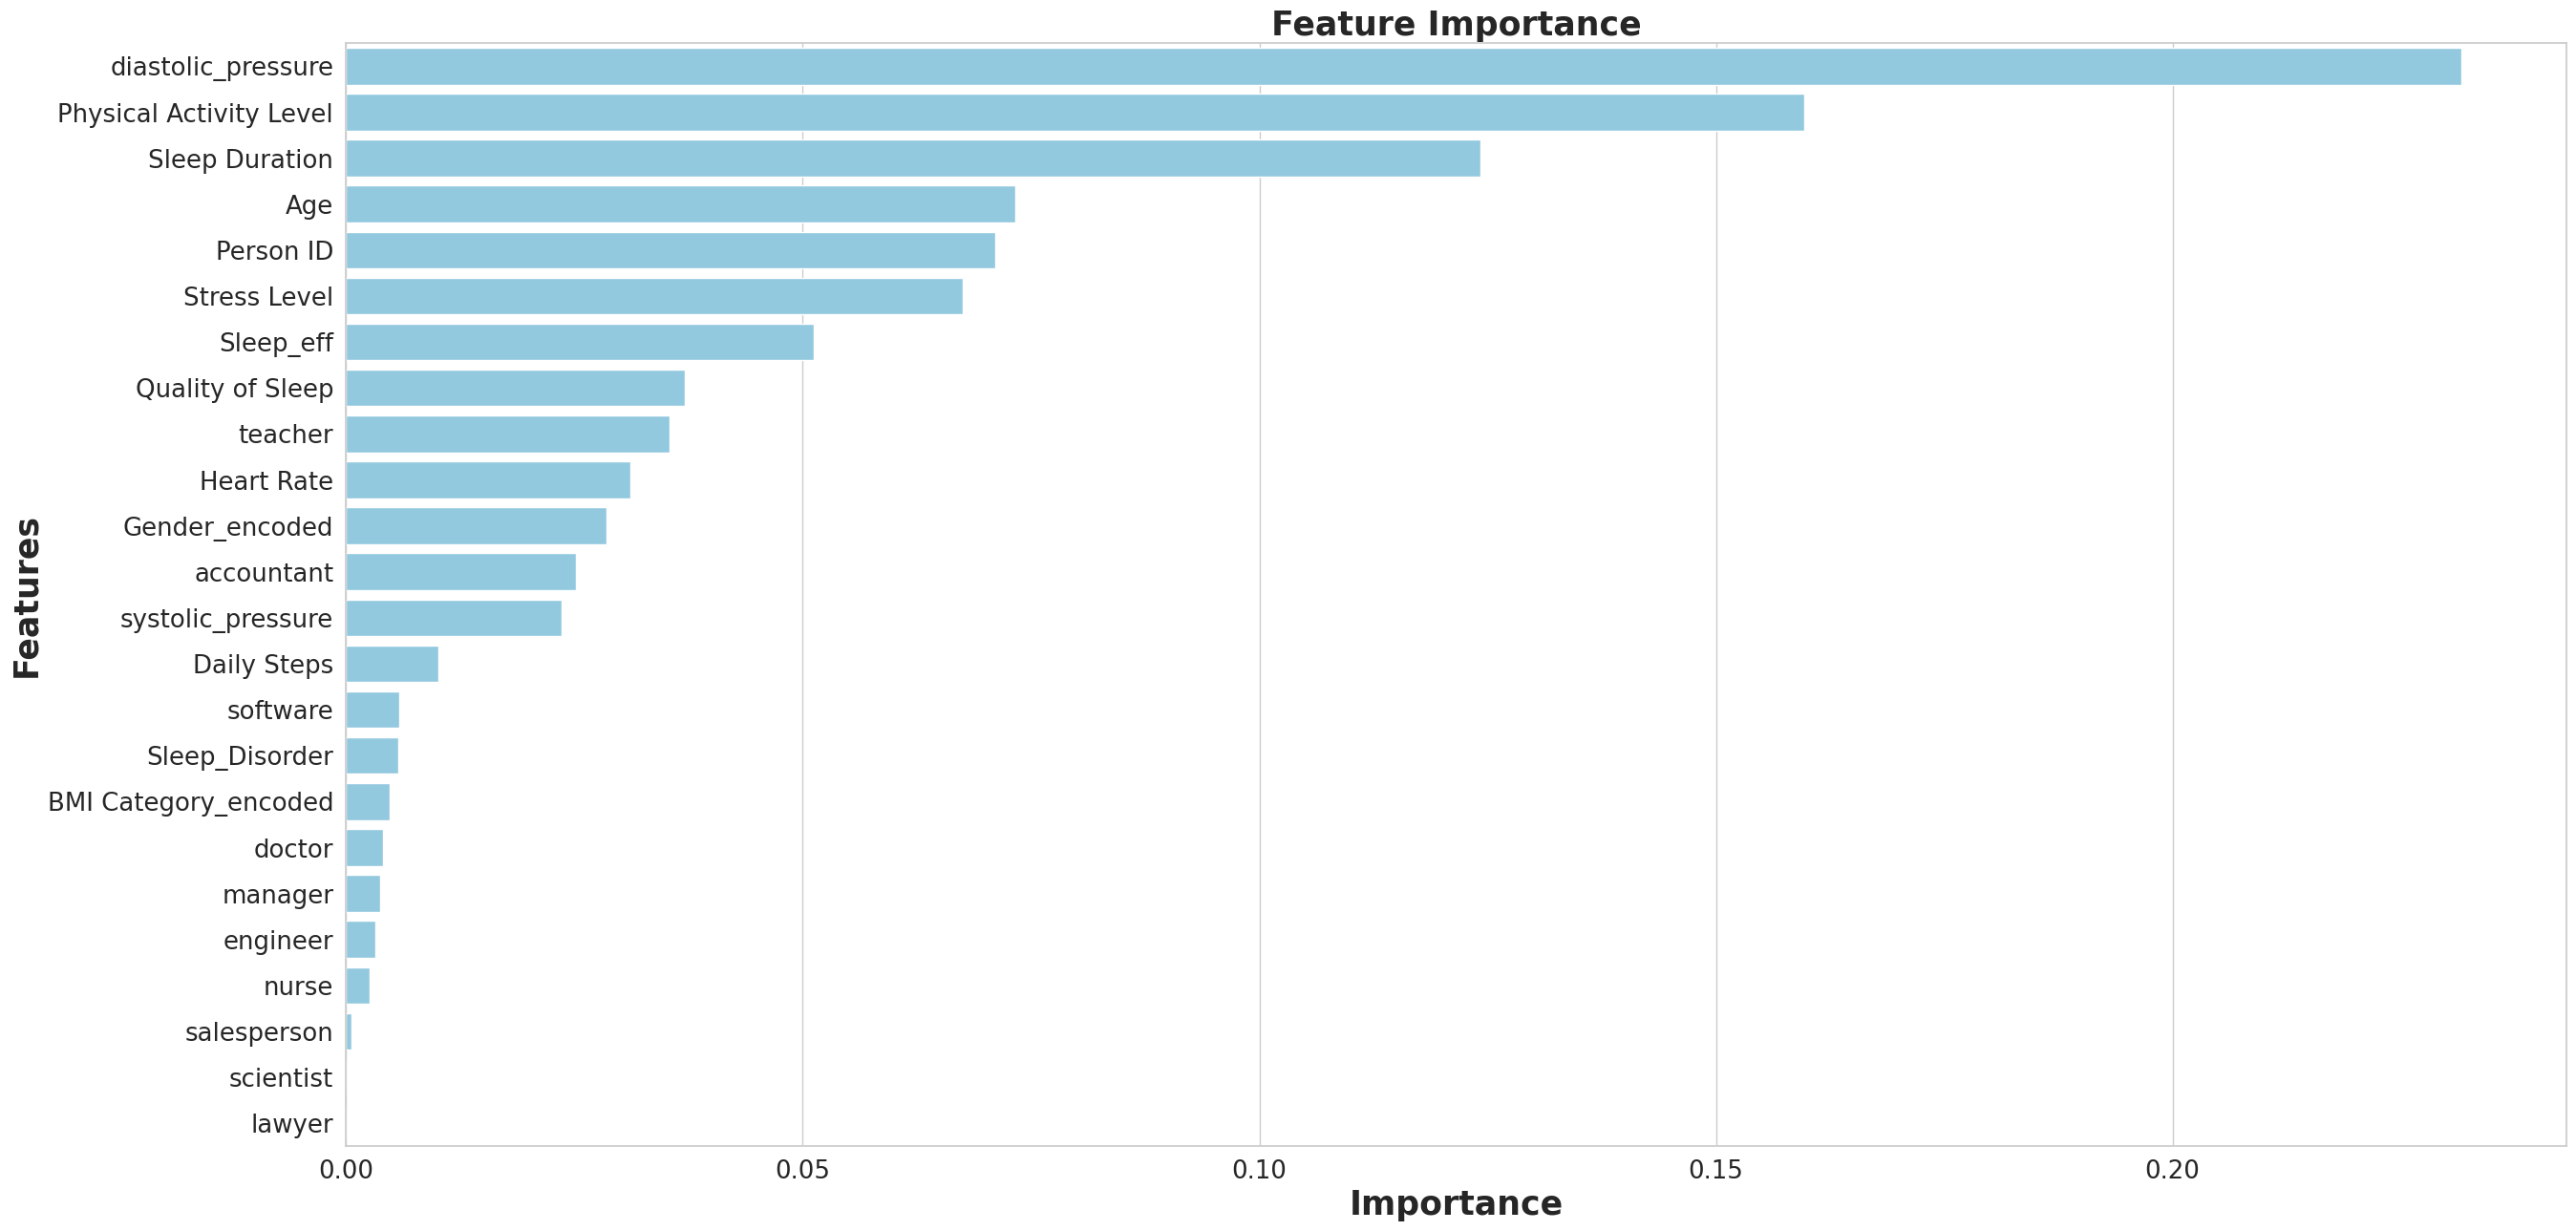

None

,Features,Gini-Importance
0,diastolic_pressure,0.231587
1,Physical Activity Level,0.159685
2,Sleep Duration,0.124231
3,Age,0.073278
4,Person ID,0.071072
5,Stress Level,0.067514
6,Sleep_eff,0.051210
7,Quality of Sleep,0.037082
8,teacher,0.035449
9,Heart Rate,0.031080


In [122]:
feats = {}
for feature, importance in zip(df.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Удаляем из датасета незначимые и производные признаки:

In [123]:
df = df.drop(['accountant', 'doctor', 'engineer', 'lawyer', 'manager', 'nurse',
       'salesperson', 'scientist', 'software', 'teacher', 'systolic_pressure',
       'diastolic_pressure', 'Sleep_eff', 'lifestyle'], axis=1)

In [124]:
X = df.drop('Quality of Sleep', axis=1)
y = df['Quality of Sleep']
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Делим датасет на три набора - тренировочный, тестовый и валидационный

In [125]:
X_train, X_validate, y_train, y_validate = train_test_split(X_tr, y_tr, test_size=0.5, random_state=42)

In [126]:
print(f"Размер X_train: {len(X_train)}")
print(f"Размер X_test: {len(X_test)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")
print(f"Размер y_validate: {len(y_validate)}")
print(f"Размер y_validate: {len(y_validate)}")

Размер X_train: 125
Размер X_test: 124
Размер y_train: 125
Размер y_test: 124
Размер y_validate: 125
Размер y_validate: 125


Используем CatBoost

In [127]:
pip install catboost

In [128]:
from catboost import CatBoostRegressor

In [129]:
regressor = CatBoostRegressor(iterations=500, depth=4, learning_rate=0.01)
regressor.fit(X_train, y_train, verbose=False)

In [130]:
predictions = regressor.predict(X_test)
print(predictions)

[8.98462056 5.99417103 6.0906854  8.98462056 5.99537378 6.14867992
 5.99805502 8.01895918 8.98095225 7.91450953 6.13724659 7.10440984
 7.93940587 5.99729245 7.93940587 6.13683149 6.0608924  6.13724659
 8.98095225 8.002579   7.08938872 7.97534443 5.99781128 6.99105442
 7.00072783 7.86555976 6.12801328 6.13777599 6.13777599 8.97931081
 7.11346677 7.9564733  7.09940567 9.01018339 6.03155491 8.01895918
 6.00617647 7.08875467 7.93940587 7.95006024 6.22599337 6.0333805
 5.59678977 6.11445314 7.8785063  8.02847435 7.90563978 7.11600047
 4.9273277  7.10067655 9.0129755  7.45535275 6.03155491 7.98030835
 6.68732446 9.0129755  7.3397856  4.53063597 8.98575903 5.99805502
 7.93023374 6.75435946 5.99805502 7.10039809 7.02936354 5.99781128
 6.13724659 8.98462056 7.95012478 6.86126322 7.92417277 6.13777599
 8.97596687 6.03149918 9.00325926 6.13777599 5.99805502 7.78967398
 9.01018339 5.7038437  7.22714498 6.02279804 7.09008998 7.88272894
 8.01895918 9.00944478 8.98605788 6.02059706 8.04177521 8.01551

In [131]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'R²: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.9728
MSE: 0.0437
MAE: 0.1064


In [132]:
predictions = regressor.predict(X_validate)
print(predictions)

[7.94930286 8.98095225 8.98462056 6.99303211 7.95077304 7.9446395
 5.99729245 7.97332948 7.88272894 6.01742746 6.0906854  9.00325926
 8.92283392 7.97332948 8.01895918 7.08875467 7.09298392 6.1380909
 8.98502042 5.75050071 5.99906402 5.80837764 8.91766096 8.98575903
 6.68732446 7.86774488 6.03155491 7.04217256 8.00117344 6.21015048
 8.90787586 8.98184522 7.97332948 5.99537378 6.88475454 7.11346677
 7.97658594 7.90563978 5.99906402 7.93023374 6.1386023  6.15065761
 7.93940587 7.08553009 6.1380909  5.45964908 7.10166896 9.01018339
 7.97332948 8.02847435 7.95012478 8.97596687 7.89650577 7.92891296
 7.03331066 7.02279294 6.10291315 7.03659243 7.97332948 6.03155491
 8.56018231 8.98184522 7.02936354 7.09002555 6.02279804 8.91766096
 5.99781128 6.09044166 7.95012478 8.00034727 7.02936354 6.00617647
 6.11680359 7.93940587 7.94813578 7.97332948 8.002579   7.97534443
 6.10930749 6.03155491 7.86555976 7.11777476 6.75435946 7.03659243
 8.98462056 6.14006859 8.98184522 7.94813578 7.87756709 6.172724

In [133]:
mse = mean_squared_error(y_validate, predictions)
mae = mean_absolute_error(y_validate, predictions)
r2 = r2_score(y_validate, predictions)

print(f'R²: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.9780
MSE: 0.0277
MAE: 0.0888


На валидационном и тестовом наборе коэффициент детерминации 0,97, что означает хорошие обобщающие показатели модели при высоких коэффициентах детерминации